In [1]:
# imports
import matplotlib
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import zoom
import json
import warnings
from random import randint
import random
import SimpleITK as sitk
from multi_slice_viewer import multi_slice_viewer
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv3D, MaxPooling3D, Dropout, Conv3DTranspose, UpSampling3D, concatenate, Cropping3D, Reshape, BatchNormalization
import keras.callbacks
from keras import backend as K
from keras import optimizers
from keras import regularizers
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical

# this part is needed if you run the notebook on Cartesius with multiple cores
n_cores = 32
config = tf.ConfigProto(intra_op_parallelism_threads=n_cores-1, inter_op_parallelism_threads=1, allow_soft_placement=True)
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = str(n_cores-1)
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

Using TensorFlow backend.


In [2]:
# Task03_liver dir in same directory as notebook
data_path = './Task03_Liver/'
print([file for file in os.listdir(data_path) if not file.startswith('.')])

['imagesTr', 'dataset.json', 'imagesTs', 'labelsTr']


In [3]:
# info about dataset in json file
with open(data_path + 'dataset.json') as f:
    d = json.load(f)
    print(d.keys())
    
    # paths to training set images with label
    train_paths = d['training']
    
    # paths to testset images with label
    test_paths = d['test'] 

dict_keys(['training', 'description', 'licence', 'labels', 'test', 'name', 'release', 'modality', 'numTest', 'numTraining', 'reference', 'tensorImageSize'])


In [4]:
# print some stuff about the dataset
print(d['tensorImageSize'])
print(d['modality'])
print(d['labels'])
print(d['numTraining'])
print(d['numTest']) 

3D
{'0': 'CT'}
{'1': 'liver', '2': 'cancer', '0': 'background'}
131
70


In [5]:
# change to data dir 
os.chdir(data_path)
print(os.getcwd())

/nfs/home4/mbotros/ISMI_project/Task03_Liver


# Load the train set as SITK images

In [6]:
# load images and labels, loading all takes some time, so just take 5 for now
train_imgs = [sitk.ReadImage(train_instance['image']) for train_instance in train_paths[100:105]]
train_lbls = [sitk.ReadImage(train_instance['label']) for train_instance in train_paths[100:105]]

for img in train_imgs:
    print(img.GetSize())

(512, 512, 333)
(512, 512, 987)
(512, 512, 188)
(512, 512, 761)
(512, 512, 122)


In [7]:
# train images as numpy
np_train_imgs = [sitk.GetArrayFromImage(i) for i in train_imgs]
np_train_lbls = [sitk.GetArrayFromImage(i) for i in train_lbls]

for img in np_train_imgs:
    print(img.shape)

(333, 512, 512)
(987, 512, 512)
(188, 512, 512)
(761, 512, 512)
(122, 512, 512)


# Spacing
Images do not have the same spacings. We will first resample. For this we need the spacings in the SITK images. Note that when converting sitk to numpy the z axis is placed at the front. Spacings in order: (x, y, z), numpy image: (z, x, y)

In [8]:
for image in train_imgs:
    print(image.GetSpacing())

(0.5976560115814209, 0.5976560115814209, 1.25)
(0.771484375, 0.771484375, 0.699999988079071)
(0.6445310115814209, 0.6445310115814209, 2.0)
(0.7820000052452087, 0.7820000052452087, 0.800000011920929)
(1.0, 1.0, 1.0)


## Resampling
to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). 
For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2),
you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm. As a tip, look for “scipy zoom”.

In [9]:
def resample(np_imgs, spacings):
    """
    Resample to 1mm x 1mm x 1mm. 
    np_imgs: list of images or labels to be resampled as numpy
    spacings: spacings to resample with, order: (z, x, y)
    """ 
    resampled = []
    
    for i in range(len(np_imgs)): 
        # apply zoom with spacing, no clue what spline interpolation is
        resampled.append(zoom(np_imgs[i], spacings[i], order=1))

    return resampled

In [10]:
# store shapes before to check
shapes_before = [img.shape for img in np_train_imgs]

# spacings from sitk images
spacings = [img.GetSpacing() for img in train_imgs]

# change order
spacings = [(z, x, y) for x, y, z in spacings]          # order: (z, x, y)

In [11]:
# resample train images and labels
np_train_imgs = resample(np_train_imgs, spacings)
np_train_lbls = resample(np_train_lbls, spacings)

/hpc/sw/python-3.5.2/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
# lets print what happened.
print("Before\t\t\tSpacings\t\tAfter")
for i in range(len(np_train_imgs)):    
    # round for printing
    spacing_round = [(round(a, 1), round(b, 1), round(c, 1)) for a, b, c in spacings]    
    print("{}\t\t{}\t\t{}".format(shapes_before[i] , spacing_round[i], np_train_imgs[i].shape))

Before			Spacings		After
(333, 512, 512)		(1.2, 0.6, 0.6)		(416, 306, 306)
(987, 512, 512)		(0.7, 0.8, 0.8)		(691, 395, 395)
(188, 512, 512)		(2.0, 0.6, 0.6)		(376, 330, 330)
(761, 512, 512)		(0.8, 0.8, 0.8)		(609, 400, 400)
(122, 512, 512)		(1.0, 1.0, 1.0)		(122, 512, 512)


In [17]:
# class for datasets
class DataSet:
    
    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls
    
    def get_lenght(self):
        return len(self.imgs)
    
    def show_image(self, i):
        if self.lbls != None: 
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial', overlay_1=self.lbls[i], overlay_1_thres=1, 
                   overlay_2=self.lbls[i], overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)
        else:
            plt.rcParams['figure.figsize'] = [8, 8]
            multi_slice_viewer(self.imgs[i], view='axial')  

# Split for training and validation

<IPython.core.display.Javascript object>


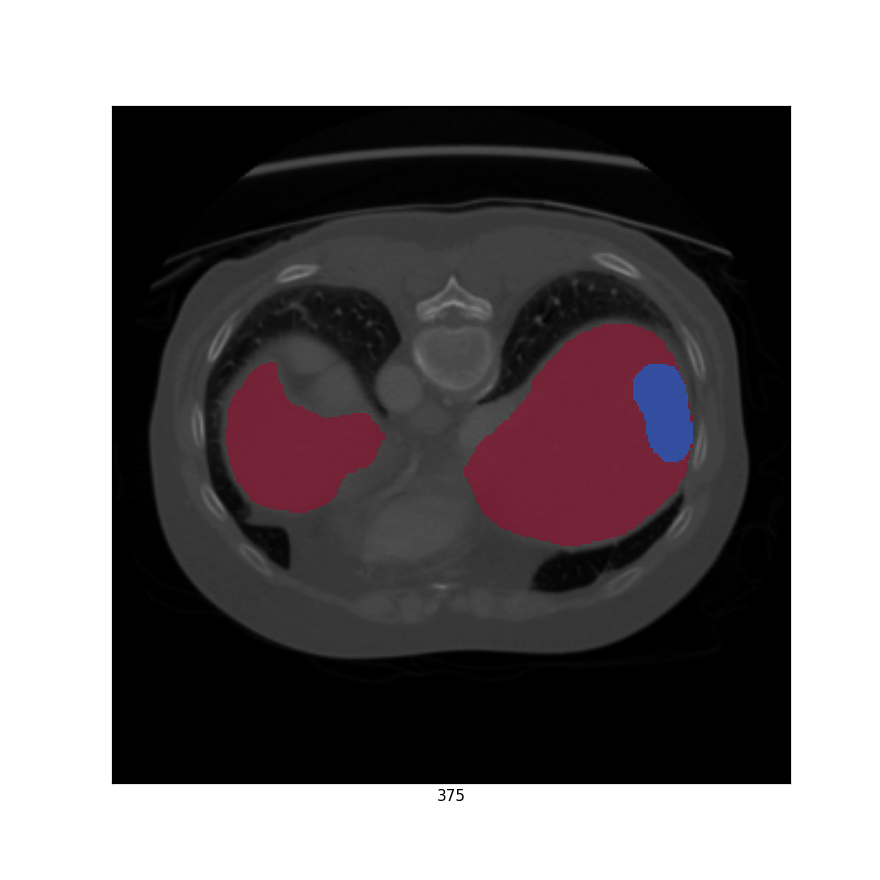

In [18]:
# make a small data set of training images, as numpy
validation_percent = 0.2 # coefficient to define validation dataset (value between 0 and 1)
n_validation_imgs = int(validation_percent * len(train_imgs))

train_set = DataSet(np_train_imgs[:n_validation_imgs], np_train_lbls[:n_validation_imgs])
val_set   = DataSet(np_train_imgs[n_validation_imgs:], np_train_lbls[n_validation_imgs:])
train_set.show_image(0)

# Patch extractor
We re-use the patch extractor from assignment 7, but modify it to get 3D patches from a 3D image.
We can add augmentations later in the patch extractor. Image intensity is normalized to [0, 1]. 
Note the extra dimension in the shape of patch_out and target_out. This doesn't work if the patch size doesn't fit in the image.

In [19]:
class PatchExtractor:

    def __init__(self, patch_size):
        self.patch_size = patch_size 
    
    def get_patch(self, image, label):
        ''' 
        Get a 3D patch of patch_size from 3D input image, along with corresponding 3D label map.
        This function works with image size >= patch_size, and pick random location of the patch inside the image.   
        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''
        
        px = self.patch_size[0]
        py = self.patch_size[1]
        pz = self.patch_size[2]
        
        # pick a random location, from which we can get a patch with patch_size, without going out of bounds
        dims = image.shape           
        r = randint(0, dims[0] - px)
        c = randint(0, dims[1] - py)
        d = randint(0, dims[2] - pz)
        
        patch  = image[r:r+px, c:c+py, d:d+pz].reshape(px, py, pz, 1)
        target = label[r:r+px, c:c+py, d:d+pz].reshape(px, py, pz, 1)

        # normalize image intensity to range [0., 1.]        
        patch = (patch - np.min(patch)) / np.ptp(patch)     
            
        return patch, target

(132, 132, 132, 1)
(132, 132, 132, 1)


<IPython.core.display.Javascript object>


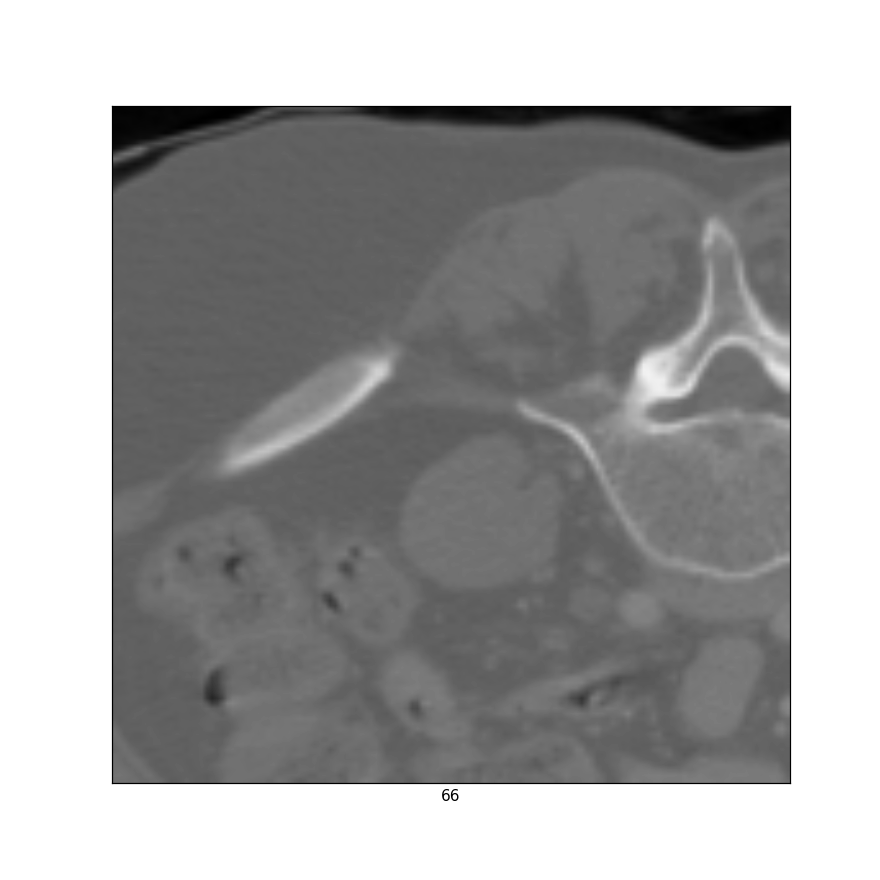

In [20]:
# get an image and a label from our train set
image = train_set.imgs[0]
label = train_set.lbls[0]

# test PatchExtractor
patch_size = (132, 132, 132)
patch_extractor = PatchExtractor(patch_size=patch_size)

# lets check some patches
patch, target = patch_extractor.get_patch(image, label)

print(patch.shape)
print(target.shape)

# show patch
plt.rcParams['figure.figsize'] = [8, 8]            
multi_slice_viewer(patch.reshape(patch_size), view='axial', overlay_1=target.reshape(patch_size), overlay_1_thres=1, 
                   overlay_2=target.reshape(patch_size), overlay_2_thres=2, overlay_2_cmap='coolwarm', overlay_2_alpha=0.75)

# Batch creator
Lets also reuse the batch creator from assignment 7. We are going to use valid convolutions, which means the output of our network will be smaller than the input. The purpose of this batchcreator is the make batches consisting of patches with their corresponding labels (for the network to train on). Since a UNet with valid convolutions has a smaller output than input, we need to crop the label based on the target size aswell. And labels should be in onehot.

In [21]:
class BatchCreator:
    
    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size # size of the output, can be useful when valid convolutions are used        
        self.imgs = dataset.imgs
        self.lbls = dataset.lbls                
        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size
    
    def create_image_batch(self, batch_size):
        '''
        returns a single (batch of?) patches (x) with corresponding labels (y) in one-hot structure
        '''
        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size, 1))  # 1 channel (??)
        y_data = np.zeros((batch_size, *self.target_size, 3)) # one-hot encoding with 3 classes
        
        for i in range(0, batch_size):
        
            random_index = np.random.choice(len(self.imgs))                   # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]       # get image and segmentation map
            patch_img, patch_lbl = self.patch_extractor.get_patch(img, lbl)   # when image size is equal to patch size, this line is useless...
        
            # crop labels based on target_size           
            ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2       # // : floor division
            pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            pd = (self.patch_extractor.patch_size[2] - self.target_size[2]) // 2
            
            # take the cropped patch, it contains labels with values 0,1,2
            cropped_patch = patch_lbl[ph:ph+self.target_size[0], pw:pw+self.target_size[1], pd:pd+self.target_size[2]].squeeze() 
            
            # instead of 0,1,2 label values we want categorical/onehot => 0: [1, 0, 0], 1: [0, 1, 0], 2: [0, 0, 1]
            onehot = to_categorical(cropped_patch, num_classes=3)
            
            x_data[i, :, :, :, :] = patch_img
            y_data[i, :, :, :, :] = onehot
        
        return (x_data.astype(np.float32), y_data.astype(np.float32))
    
    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)

# 3D UNet Model
Start with this model, we can adapt this later if needed. Build like the net from: 
3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.

In [22]:
# make block of two convolve3D's
def unet_block(inputs, n_filters, padding, up_conv=False, batchnorm=False):
    # 3d convolve, 32 3x3x3 filters 
    c1 = Conv3D(n_filters, (3,3,3), activation='relu', padding=padding)(inputs)
    if batchnorm:
        c1 = BatchNormalization()(c1)
    
    # up conv (normal conv in the expanding path) has same number of filters twice
    if up_conv:
        c2 = Conv3D(n_filters, (3, 3, 3), activation='relu', padding=padding)(c1)
    else:          # normal convs have twice the filters in the second conv
        c2 = Conv3D(n_filters*2, (3, 3, 3), activation='relu', padding=padding)(c1)
        
    if batchnorm:
        c2 = BatchNormalization()(c2)
    
    return c2

In [23]:
# 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation. Ozgun Cicek et al, 2016.
def build_unet_3d(initial_filters, padding, batchnorm=True):
    
    ## CONTRACTING PATH

    # (spac_dim_1, space_dim_2, space_dim_3, channels)
    inputs = Input(shape=(132, 132, 132, 1))

    # First conv pool, 32 filters and 64 filters    
    block_1    = unet_block(inputs, initial_filters, padding=padding, batchnorm=batchnorm) 
    max_pool_1 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_1)  # 2×2×2 max pooling with strides two
                                                                        # needs even spacial_dimensions as input
    # second conv pool, 64 filters, 128 filters    
    block_2    = unet_block(max_pool_1, initial_filters*2, padding=padding, batchnorm=batchnorm)
    max_pool_2 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_2)
    
    # third conv pool, 128 filters, 256 filters    
    block_3    = unet_block(max_pool_2, initial_filters*4, padding=padding, batchnorm=batchnorm)
    max_pool_3 = MaxPooling3D(pool_size=(2, 2, 2), strides=2)(block_3)
    
    # just a conv block without maxpooling, 256 filters and 512 filters
    conv_4     = unet_block(max_pool_3, initial_filters*8, padding=padding, batchnorm=batchnorm)
    
    ## EXPANDING PATH   
    
    #TODO: check Conv3DTranspose correctly applied
    
    # round 1
    up_conv_3  = Conv3DTranspose(16*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(conv_4)
    crop_3     = Cropping3D(cropping=4)(block_3) 
    concat_3   = concatenate([crop_3, up_conv_3])  
    up_block_3 = unet_block(concat_3, 8*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 2
    up_conv_2  = Conv3DTranspose(8*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_3) 
    crop_2     = Cropping3D(cropping=16)(block_2) 
    concat_2   = concatenate([crop_2, up_conv_2])  
    up_block_2 = unet_block(concat_2, 4*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # round 3
    up_conv_1  = Conv3DTranspose(4*initial_filters, (2, 2, 2), strides=(2, 2, 2), padding=padding)(up_block_2) 
    crop_1     = Cropping3D(cropping=40)(block_1) 
    concat_1   = concatenate([crop_1, up_conv_1])  
    up_block_1 = unet_block(concat_1, 2*initial_filters, padding, up_conv=True, batchnorm=batchnorm)
    
    # finish with 1x1x1 conv, 3 filters, # labels, softmax or ReLU?
    finish = Conv3D(3, (1,1,1), activation='softmax', padding=padding)(up_block_1)
    
    model = Model(inputs, finish) 
    print(model.summary(line_length=150))
    
    return model

In [24]:
unet_3d = build_unet_3d(initial_filters=32, padding='valid')

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             (None, 132, 132, 132, 1)         0                                                                   
______________________________________________________________________________________________________________________________________________________
conv3d_1 (Conv3D)                                (None, 130, 130, 130, 32)        896               input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
batch_normalization_1 (BatchNormalization)       (None, 130, 130, 130, 32)        128         

In [25]:
# Not sure how this still isn't exactly the same parameters as the paper (19,069,955). Close enough tho.

## Testing the batch generator

In [26]:
# define parameters for the batch creator
patch_size  = (132, 132, 132)  # isotropic patch size
target_size = (44, 44, 44)     # output size, smaller since valid convolutions are used
batch_size = 1                 # number of patches in a mini-batch, for segmentation 1 is fine, since the 
                               # output of the net is many thousands of values per patch, which all contribute to the loss

# initialize patch generator and batch creator
patch_generator       = PatchExtractor(patch_size)
batch_generator_train = BatchCreator(patch_generator, train_set, target_size=target_size)
batch_generator_val   = BatchCreator(patch_generator, val_set, target_size=target_size)

# get one minibatch
x_data, y_data = batch_generator_train.create_image_batch(batch_size)

print("(batch, d, h, w, channels)")
print('xdata has shape: {}'.format(x_data.shape))
print('ydata has shape: {}'.format(y_data.shape))
print('Occuring values in true labels: {}'.format(np.unique(y_data)))
print('Min of input: {}'.format(np.min(x_data)))
print('Max of input: {}'.format(np.max(x_data)))

(batch, d, h, w, channels)
xdata has shape: (1, 132, 132, 132, 1)
ydata has shape: (1, 44, 44, 44, 3)
Occuring values in true labels: [0. 1.]
Min of input: 0.0
Max of input: 1.0


## Now we define parameters, compile the model and train the network 

In [27]:
learning_rate   = 0.001
# optimizer       = SGD(lr=learning_rate, momentum=0.9, nesterov=True)
optimizer       = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
loss            = 'categorical_crossentropy'
metrics         = ['accuracy']  # probably not useful (?)
steps_per_epoch = 10
epochs          = 10

image_generator_train = batch_generator_train.get_image_generator(batch_size)
image_generator_val   = batch_generator_val.get_image_generator(batch_size)

# compile model
unet_3d.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# train the model
hist = unet_3d.fit_generator(generator=image_generator_train, 
                    steps_per_epoch=steps_per_epoch, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=image_generator_val,
                    validation_steps=1)

Epoch 1/10
10/10 [==============================] - 137s 14s/step - loss: 1.5474 - acc: 0.2027 - val_loss: 11.7607 - val_acc: 0.2649
Epoch 2/10
10/10 [==============================] - 128s 13s/step - loss: 1.1334 - acc: 0.3128 - val_loss: 0.5599 - val_acc: 0.9653
Epoch 3/10
10/10 [==============================] - 128s 13s/step - loss: 0.9634 - acc: 0.6228 - val_loss: 16.1191 - val_acc: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 126s 13s/step - loss: 0.9151 - acc: 0.7284 - val_loss: 5.0054e-04 - val_acc: 0.9998
Epoch 5/10
10/10 [==============================] - 127s 13s/step - loss: 0.8141 - acc: 0.8584 - val_loss: 1.1010 - val_acc: 0.7700
Epoch 6/10
10/10 [==============================] - 126s 13s/step - loss: 0.7501 - acc: 0.9467 - val_loss: 1.7509 - val_acc: 3.6392e-04
Epoch 7/10
10/10 [==============================] - 128s 13s/step - loss: 0.7408 - acc: 0.8944 - val_loss: 10.4894 - val_acc: 0.0736
Epoch 8/10
10/10 [==============================] - 127s 13s/

ValueError: empty range for randrange() (0,-9, -9)

**This happens. because it patch size doesn't always fit. So we are going to have to modify the patch extractor**

## Check how training went

In [ ]:
# plot training info
plt.figure()
plt.plot(range(epochs), hist.history['loss'], label='train loss')
plt.plot(range(epochs), hist.history['acc'], label='train acc')
plt.plot(range(epochs), hist.history['val_loss'], label='val loss')
plt.plot(range(epochs), hist.history['val_acc'], label='val acc')
plt.legend(loc='upper right')
plt.show()

## Getting the full segmentation map
Like this but then 3D:

![seg_diagram.png](seg_diagram.png)


In [ ]:
def padding(input_image, target_size):
    """
    Adding the red border (see example above) to the image. Which is needed for when we don't have full context. 
    Pad with lowest occuring values.
    input_image : the input image (as numpy)
    target_size : output size of the model, needed to calculate how much to padd in each dimension. 
    """
    return None
    

In [ ]:
def predict_image_segmentation(model, input_image, target_size):
    """
    Give a full segmentation map (same size as input_image) using the model. 
    model       : the model to do the prediction
    input_image : the input image (as numpy)
    target_size : output size of the model (since we use valid convutions the output gets smaller)
    """
    dims = input_image.shape
    segmentation = np.zeros((dims[0], dims[1], dims[2])) 
    
    # first do the ones where we will use the full pred, for the last one we are gonna need to crop.
    # how many times target size fits in a dimension
    pz = dims[0] // target_size[0]
    px = dims[1] // target_size[1]
    py = dims[2] // target_size[2]
    
    # pad the input image 
    pad_image = None

    for z in range(pz):
        for x in range(px):
            for y in range(py):
                segmentation[z:z+target_size[0], 
                             x:x+target_size[1], 
                             y:y+target_size[2]] = None
                
    return segmentation            
                          
# kan je nog wat dingen uit gebruiken.                
#     for x_pos in range(0, dim[0] - (dim[0] % patch_size[0]), patch_size[0]): 
#         for y_pos in range(0, dim[1] - (dim[1] % patch_size[1]), patch_size[1]):
#             for z_pos in range(0, dim[2] - (dim[2] % patch_size[2]), patch_size[2]):
                
#                 # Get patch and add padding: 
#                 patch = input_image[x_pos:patch_size[0], y_pos:patch_size[1], z_pos:patch_size[2]]
#                 padded = pad_prediction(patch, padded_size, patch_size)
                
#                 # Reshape for u-net and make prediction:
#                 padded = np.reshape(padded, (1, padded_size[0], padded_size[1], padded_size[2], 1))
#                 prediction = unet.predict(padded)
#                 prediction = np.argmax(np.squeeze(prediction), axis=3)
                
#                 # Segmentation is the highest number of [background, liver, cancer]:
#                 segmentation[x_pos:x_pos + patch_size[0], y_pos:y_pos + patch_size[1], z_pos:z_pos + patch_size[2]] =  prediction 
    

In [ ]:
# take an image and a label from train set
image = train_set.imgs[0]
label = train_set.lbls[0]
print(image.shape)
print(target_size)

In [ ]:
#segmentation = predict_image_segmentation(unet_3d, image, target_size)

## TODO: 
1. ~~Setting the spacing should not effect width. Resampling to 1mm x 1mm x 1mm resolution => images should have different sizes (not all 512 x 512 x N anymore). For example, when the image has a shape of (512, 512, 74) and a spacing of (0.75, 0.75, 2), you can calculate how wide the image is along the x-axis: 512 * 0.75 mm = 384 mm.  As a tip, look for “scipy zoom”.~~ **(Done, but is it correct like this?)**
2. ~~Choose a patch size that is also isotropic because otherwise you would include less information / context in some direction.~~
3. Modifiy the patch extractor that when the patch size doesn't fit we pad the lowest occuring value for missing data. (only for a few cases, might not be a disaster). I think Niko also means we shouldn't randomly extract patches for training the model, but extract patches in the same way we would for a full segmentation (which also makes sense).
4. Find good patch_size (+ padded_size) for images -> full segmentation function.

## Do this stuff later:
* Train network and plot loss, including loss on validation data on epoch end and saving the best model. (see keras.callbacks.Callback)
* Add dice loss (note that we do not have binary labels at the moment).
* Should we shuffle the data?